In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install pmdarima

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
from itertools import product
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#import pmdarima as pm

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [3]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [4]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [5]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 복잡한 컬럼명 변경

In [6]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [7]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


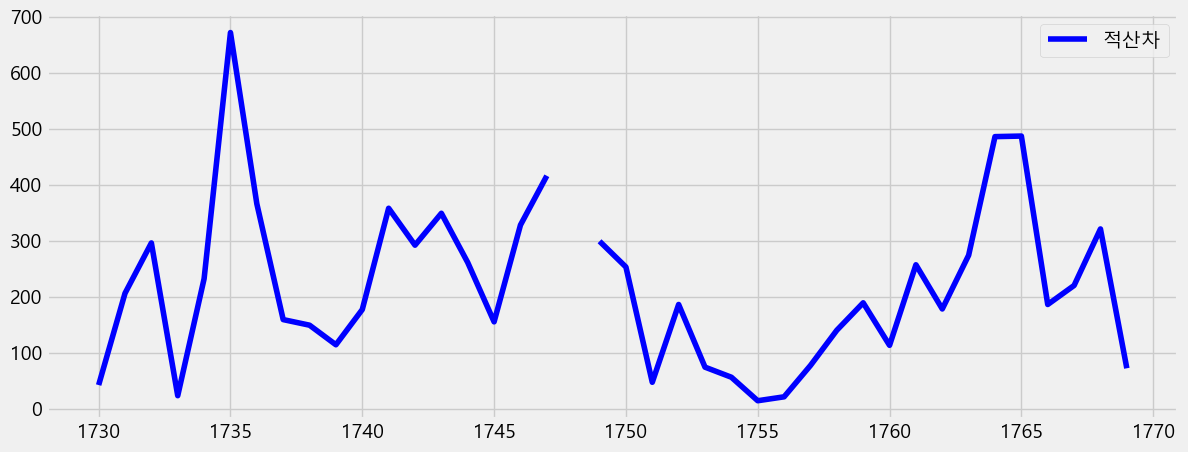

In [8]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

In [9]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

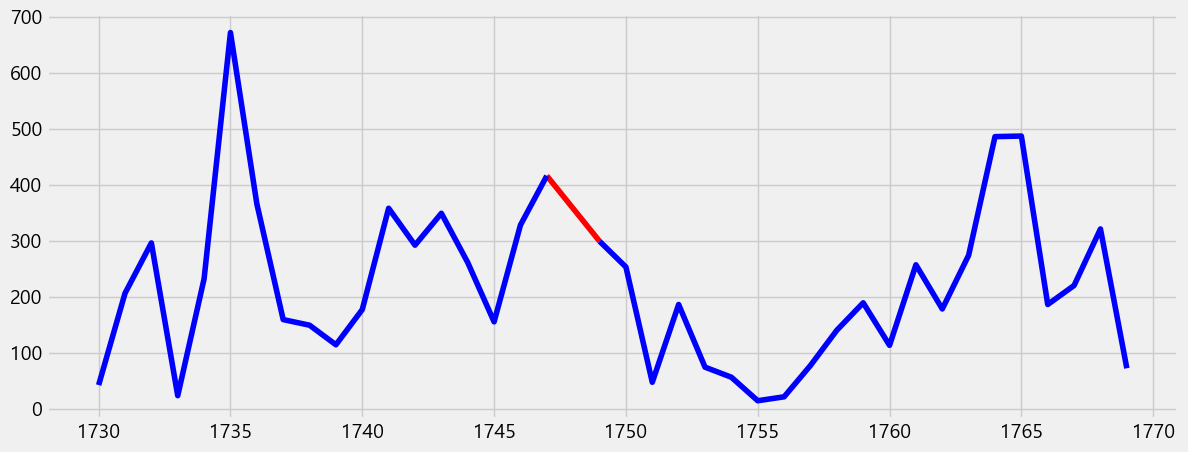

In [10]:
# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 변환

#### 이상치 제거

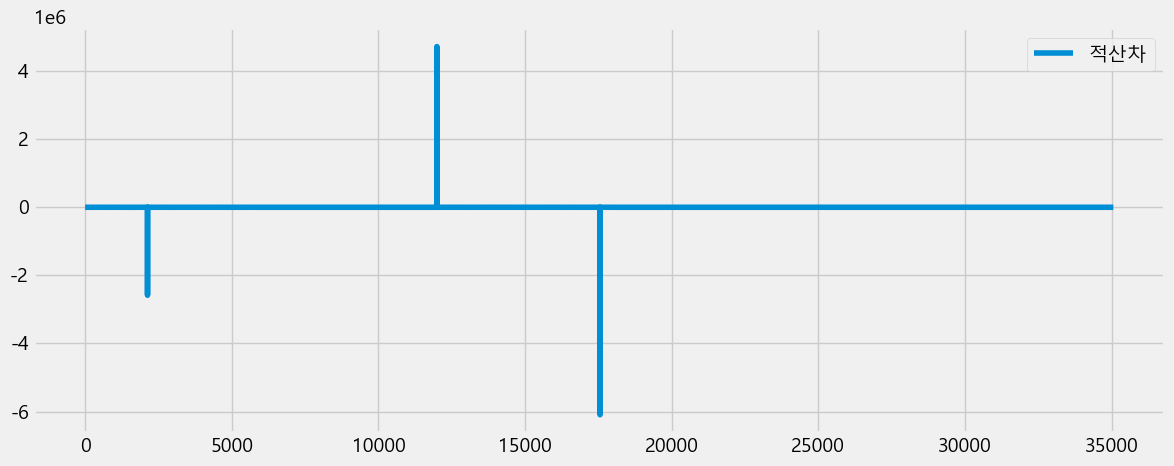

In [11]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plt.show()

In [12]:
data_tr[data_tr.적산차 == max(data_tr.적산차)]

,datetime,적산차
11995,2018-05-15 20:00:00,4720655.0


In [13]:
data_tr[data_tr.적산차 == min(data_tr.적산차)]

,datetime,적산차
17558,2019-01-02 15:00:00,-6093821.0


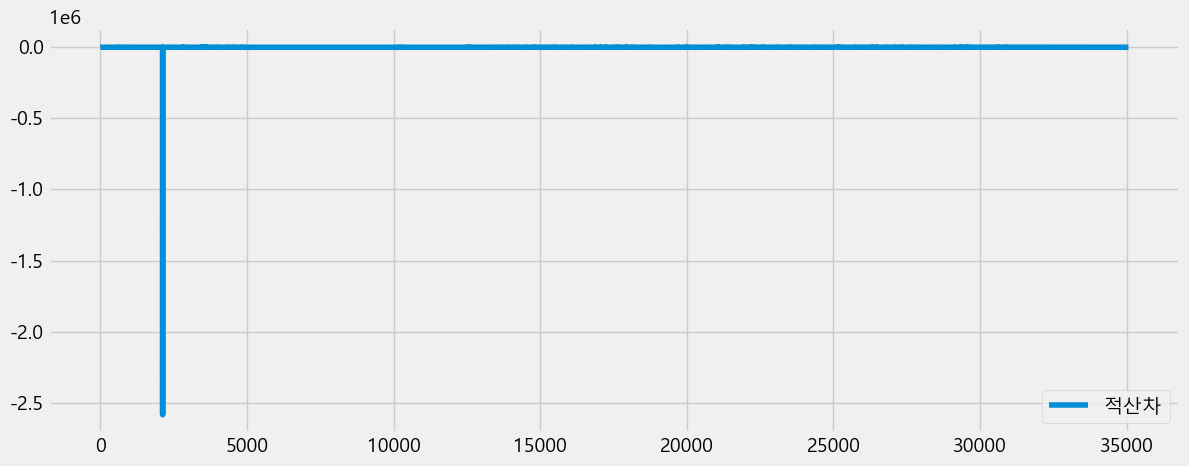

In [14]:
data_tr.drop(index=[11995, 17558], inplace=True)
data_tr.plot()
plt.show()

In [15]:
data_tr[data_tr.적산차 == min(data_tr.적산차)]

,datetime,적산차
2127,2017-03-30 16:00:00,-2584551.0


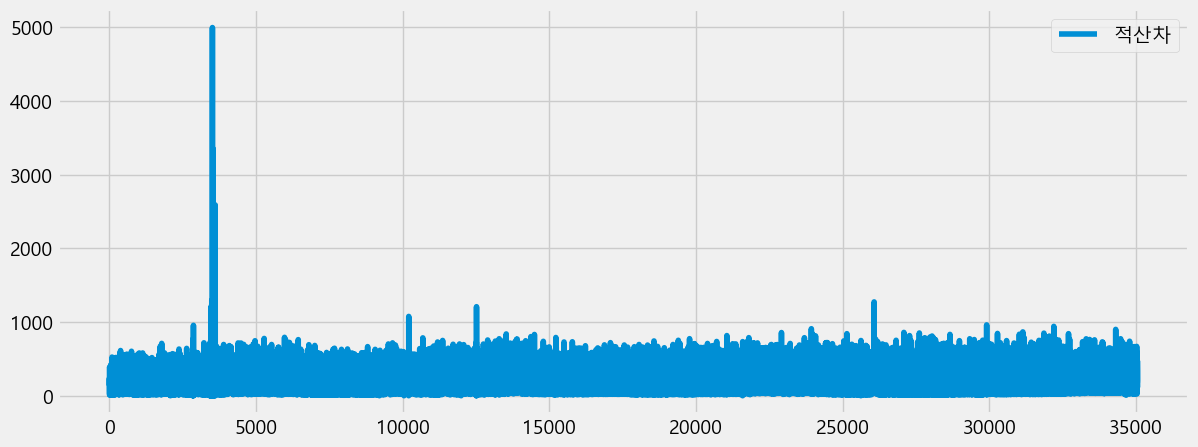

In [16]:
data_tr.drop(index=2127, inplace=True)
data_tr.plot()
plt.show()

In [17]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [18]:
data_tr.reset_index(drop=True, inplace=True)

In [19]:
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)
data_tr.head()

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0


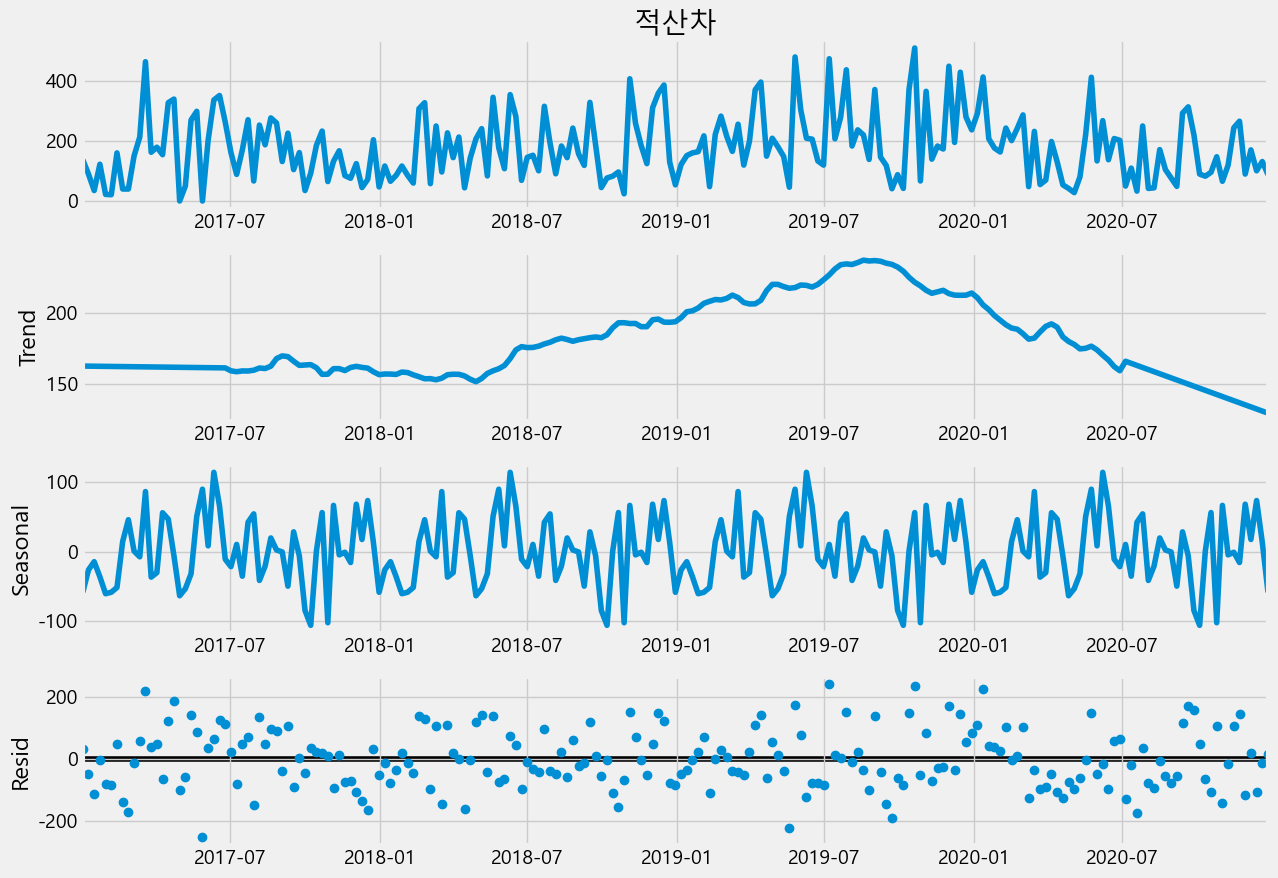

In [20]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 1년의 계절성을 지녔음

### Prophet 모델

In [21]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index

# yearly_Seasonality를 지닌 모델을 생성
m= Prophet(seasonality_mode='multiplicative',
          yearly_seasonality=True,
          changepoint_range=0.8,
          changepoint_prior_scale=0.2)
m.fit(data_tr_prophet)
period = 0
future = m.make_future_dataframe(periods=period, freq='H')
forecast = m.predict(future)

01:25:15 - cmdstanpy - INFO - Chain [1] start processing
01:25:31 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# 학습데이터와 예측치를 비교
forecast['original'] = list(data_tr_prophet.y) + [np.nan]*period
forecast.rename(columns={'yhat':'predict'}, inplace=True)
forecast = forecast[['ds', 'original', 'predict']]

mae = mean_absolute_error(forecast[:35060]['original'], forecast[:35060]['predict'])
print('mae :', mae)

forecast

mae : 93.64309349919488


,ds,original,predict
0,2017-01-01 01:00:00,138.0,115.216715
1,2017-01-01 02:00:00,237.0,71.577510
2,2017-01-01 03:00:00,128.0,35.546131
3,2017-01-01 04:00:00,14.0,9.489044
4,2017-01-01 05:00:00,11.0,2.747398
...,...,...,...
35055,2020-12-31 19:00:00,328.0,316.536298
35056,2020-12-31 20:00:00,347.0,375.803895
35057,2020-12-31 21:00:00,335.0,417.775658
35058,2020-12-31 22:00:00,141.0,414.980067


#### gridsearch 구현

In [22]:
changepoint_range = np.arange(0.5, 0.95, 0.05)
changepoint_prior_scale = np.arange(0.05, 0.95, 0.05)
cnt, best_mae = 0, ' '

for cr in tqdm(changepoint_range):
    cr = round(cr, 2)
    for cps in changepoint_prior_scale:
        cps = round(cps, 2)
        cnt += 1
        
        m= Prophet(seasonality_mode='multiplicative',
          yearly_seasonality=True,
          changepoint_range=cr,
          changepoint_prior_scale=cps)
        m.fit(data_tr_prophet)
        future = pd.DataFrame({'ds':data_ts['datetime'][:336]})
        forecast = m.predict(future)
        
        forecast['original'] = data_ts[:336].적산차
        forecast.rename(columns={'yhat':'predict'}, inplace=True)
        forecast = forecast[['ds', 'original', 'predict']]

        mae = mean_absolute_error(forecast['original'], forecast['predict'])
        print('cr, cps : {}, {}, mae : {}'.format(cr, cps, mae), 'best mae :', best_mae)

        if cnt == 1:
            best_mae = mae
        
        if best_mae > mae:
            best_mae, best_cr, best_cps = mae, cr, cps

  0%|          | 0/9 [00:00<?, ?it/s]15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.05, mae : 99.82999698410252 best mae :  


15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.1, mae : 99.99560494365008 best mae : 99.82999698410252


15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.15, mae : 99.81363153693283 best mae : 99.82999698410252


15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:14 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.2, mae : 99.7693815866698 best mae : 99.81363153693283


15:18:16 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.25, mae : 99.67835746206728 best mae : 99.7693815866698


15:18:27 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.3, mae : 99.87639693617248 best mae : 99.67835746206728


15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.35, mae : 99.85415683896687 best mae : 99.67835746206728


15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.4, mae : 100.00321122132118 best mae : 99.67835746206728


15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.45, mae : 99.53709222723877 best mae : 99.67835746206728


15:19:12 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.5, mae : 99.93086093224994 best mae : 99.53709222723877


15:19:29 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.55, mae : 99.71746293728269 best mae : 99.53709222723877


15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.6, mae : 99.56189729803823 best mae : 99.53709222723877


15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.65, mae : 99.96043882127807 best mae : 99.53709222723877


15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.7, mae : 99.64809296619214 best mae : 99.53709222723877


15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.75, mae : 99.785783833561 best mae : 99.53709222723877


15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.8, mae : 99.89463048531859 best mae : 99.53709222723877


15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:52 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.5, 0.85, mae : 99.48723161444184 best mae : 99.53709222723877


15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:21:06 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [03:39<29:13, 219.14s/it]

cr, cps : 0.5, 0.9, mae : 100.00913605168095 best mae : 99.48723161444184


15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.05, mae : 99.90501915567464 best mae : 99.48723161444184


15:21:18 - cmdstanpy - INFO - Chain [1] start processing
15:21:28 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.1, mae : 99.89724276298536 best mae : 99.48723161444184


15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:42 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.15, mae : 99.85372339075987 best mae : 99.48723161444184


15:21:45 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.2, mae : 99.84475911696299 best mae : 99.48723161444184


15:22:00 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.25, mae : 99.78208559140538 best mae : 99.48723161444184


15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:21 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.3, mae : 99.85942528128031 best mae : 99.48723161444184


15:22:23 - cmdstanpy - INFO - Chain [1] start processing
15:22:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.35, mae : 99.83821348050435 best mae : 99.48723161444184


15:22:37 - cmdstanpy - INFO - Chain [1] start processing
15:22:49 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.4, mae : 99.9070373528615 best mae : 99.48723161444184


15:22:51 - cmdstanpy - INFO - Chain [1] start processing
15:23:03 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.45, mae : 99.83392213070745 best mae : 99.48723161444184


15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:16 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.5, mae : 99.79068919380396 best mae : 99.48723161444184


15:23:19 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.55, mae : 99.87148724715392 best mae : 99.48723161444184


15:23:33 - cmdstanpy - INFO - Chain [1] start processing
15:23:44 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.6, mae : 99.7377756522643 best mae : 99.48723161444184


15:23:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.65, mae : 99.93140539482121 best mae : 99.48723161444184


15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.7, mae : 99.95703044572912 best mae : 99.48723161444184


15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.75, mae : 99.97681522710619 best mae : 99.48723161444184


15:24:33 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.8, mae : 99.99708228963024 best mae : 99.48723161444184


15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:59 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.55, 0.85, mae : 99.64033804181187 best mae : 99.48723161444184


15:25:01 - cmdstanpy - INFO - Chain [1] start processing
15:25:13 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [07:45<27:26, 235.23s/it]

cr, cps : 0.55, 0.9, mae : 99.99456118893465 best mae : 99.48723161444184


15:25:15 - cmdstanpy - INFO - Chain [1] start processing
15:25:22 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.05, mae : 99.79164701429112 best mae : 99.48723161444184


15:25:25 - cmdstanpy - INFO - Chain [1] start processing
15:25:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.1, mae : 99.66003720605254 best mae : 99.48723161444184


15:25:35 - cmdstanpy - INFO - Chain [1] start processing
15:25:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.15, mae : 99.74561074894856 best mae : 99.48723161444184


15:25:45 - cmdstanpy - INFO - Chain [1] start processing
15:25:57 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.2, mae : 99.75217536452995 best mae : 99.48723161444184


15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.25, mae : 99.53883673582352 best mae : 99.48723161444184


15:26:10 - cmdstanpy - INFO - Chain [1] start processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.3, mae : 99.66687227853778 best mae : 99.48723161444184


15:26:25 - cmdstanpy - INFO - Chain [1] start processing
15:26:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.35, mae : 99.62639022054502 best mae : 99.48723161444184


15:26:35 - cmdstanpy - INFO - Chain [1] start processing
15:26:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.4, mae : 99.51749288002524 best mae : 99.48723161444184


15:26:47 - cmdstanpy - INFO - Chain [1] start processing
15:26:59 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.45, mae : 99.68979011037804 best mae : 99.48723161444184


15:27:02 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.5, mae : 99.57348333064786 best mae : 99.48723161444184


15:27:17 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.55, mae : 99.60302424814196 best mae : 99.48723161444184


15:27:32 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.6, mae : 99.66611938704942 best mae : 99.48723161444184


15:27:47 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.65, mae : 99.64368276672356 best mae : 99.48723161444184


15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:15 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.7, mae : 99.85777036897504 best mae : 99.48723161444184


15:28:18 - cmdstanpy - INFO - Chain [1] start processing
15:28:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.75, mae : 99.9284045446974 best mae : 99.48723161444184


15:28:33 - cmdstanpy - INFO - Chain [1] start processing
15:28:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.8, mae : 99.60220429704243 best mae : 99.48723161444184


15:28:46 - cmdstanpy - INFO - Chain [1] start processing
15:28:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.6, 0.85, mae : 99.6441982706841 best mae : 99.48723161444184


15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [11:47<23:49, 238.19s/it]

cr, cps : 0.6, 0.9, mae : 99.72571290931215 best mae : 99.48723161444184


15:29:17 - cmdstanpy - INFO - Chain [1] start processing
15:29:26 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.05, mae : 99.67547614862144 best mae : 99.48723161444184


15:29:28 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.1, mae : 99.74257960348925 best mae : 99.48723161444184


15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.15, mae : 99.67917013364712 best mae : 99.48723161444184


15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.2, mae : 99.55595591820523 best mae : 99.48723161444184


15:30:03 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.25, mae : 99.59927621048762 best mae : 99.48723161444184


15:30:16 - cmdstanpy - INFO - Chain [1] start processing
15:30:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.3, mae : 99.6737878760512 best mae : 99.48723161444184


15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.35, mae : 99.50041088955598 best mae : 99.48723161444184


15:30:36 - cmdstanpy - INFO - Chain [1] start processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.4, mae : 99.56534396406599 best mae : 99.48723161444184


15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.45, mae : 99.34674314615438 best mae : 99.48723161444184


15:31:01 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.5, mae : 99.32969107824655 best mae : 99.34674314615438


15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.55, mae : 99.76146840714104 best mae : 99.32969107824655


15:31:27 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.6, mae : 99.6778151181437 best mae : 99.32969107824655


15:31:41 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.65, mae : 100.00727875819298 best mae : 99.32969107824655


15:31:48 - cmdstanpy - INFO - Chain [1] start processing
15:31:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.7, mae : 99.48304223960791 best mae : 99.32969107824655


15:31:59 - cmdstanpy - INFO - Chain [1] start processing
15:32:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.75, mae : 99.73301890352866 best mae : 99.32969107824655


15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:27 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.8, mae : 99.7658522686701 best mae : 99.32969107824655


15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.65, 0.85, mae : 99.56010517772964 best mae : 99.32969107824655


15:32:41 - cmdstanpy - INFO - Chain [1] start processing
15:32:49 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [15:21<19:03, 228.66s/it]

cr, cps : 0.65, 0.9, mae : 99.24222530761307 best mae : 99.32969107824655


15:32:51 - cmdstanpy - INFO - Chain [1] start processing
15:32:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.05, mae : 99.77151012726013 best mae : 99.24222530761307


15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.1, mae : 99.68243067782107 best mae : 99.24222530761307


15:33:14 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.15, mae : 99.73063708793458 best mae : 99.24222530761307


15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.2, mae : 99.8208922908935 best mae : 99.24222530761307


15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.25, mae : 99.78989819786966 best mae : 99.24222530761307


15:33:49 - cmdstanpy - INFO - Chain [1] start processing
15:34:02 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.3, mae : 99.78670205106097 best mae : 99.24222530761307


15:34:05 - cmdstanpy - INFO - Chain [1] start processing
15:34:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.35, mae : 99.7557740814834 best mae : 99.24222530761307


15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.4, mae : 99.6982371136857 best mae : 99.24222530761307


15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.45, mae : 99.81011333773897 best mae : 99.24222530761307


15:34:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:04 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.5, mae : 99.91847930108955 best mae : 99.24222530761307


15:35:07 - cmdstanpy - INFO - Chain [1] start processing
15:35:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.55, mae : 99.86218474831487 best mae : 99.24222530761307


15:35:21 - cmdstanpy - INFO - Chain [1] start processing
15:35:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.6, mae : 99.78270131331139 best mae : 99.24222530761307


15:35:35 - cmdstanpy - INFO - Chain [1] start processing
15:35:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.65, mae : 99.60085872054164 best mae : 99.24222530761307


15:35:47 - cmdstanpy - INFO - Chain [1] start processing
15:35:58 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.7, mae : 99.69018135360442 best mae : 99.24222530761307


15:36:01 - cmdstanpy - INFO - Chain [1] start processing
15:36:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.75, mae : 99.70702544934598 best mae : 99.24222530761307


15:36:16 - cmdstanpy - INFO - Chain [1] start processing
15:36:30 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.8, mae : 99.76679950705022 best mae : 99.24222530761307


15:36:33 - cmdstanpy - INFO - Chain [1] start processing
15:36:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.7, 0.85, mae : 99.73273862012292 best mae : 99.24222530761307


15:36:48 - cmdstanpy - INFO - Chain [1] start processing
15:37:02 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [19:34<15:50, 237.57s/it]

cr, cps : 0.7, 0.9, mae : 99.80552256304227 best mae : 99.24222530761307


15:37:04 - cmdstanpy - INFO - Chain [1] start processing
15:37:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.05, mae : 99.86376237872967 best mae : 99.24222530761307


15:37:13 - cmdstanpy - INFO - Chain [1] start processing
15:37:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.1, mae : 99.80877569888352 best mae : 99.24222530761307


15:37:27 - cmdstanpy - INFO - Chain [1] start processing
15:37:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.15, mae : 99.87399851777388 best mae : 99.24222530761307


15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:57 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.2, mae : 99.74291060495628 best mae : 99.24222530761307


15:37:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:09 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.25, mae : 99.63063418565976 best mae : 99.24222530761307


15:38:12 - cmdstanpy - INFO - Chain [1] start processing
15:38:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.3, mae : 99.88826348018631 best mae : 99.24222530761307


15:38:28 - cmdstanpy - INFO - Chain [1] start processing
15:38:36 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.35, mae : 99.75633244151844 best mae : 99.24222530761307


15:38:39 - cmdstanpy - INFO - Chain [1] start processing
15:38:47 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.4, mae : 99.73334950620603 best mae : 99.24222530761307


15:38:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.45, mae : 99.73368524600296 best mae : 99.24222530761307


15:39:03 - cmdstanpy - INFO - Chain [1] start processing
15:39:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.5, mae : 99.77702162533681 best mae : 99.24222530761307


15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:24 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.55, mae : 99.63451381806685 best mae : 99.24222530761307


15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.6, mae : 99.79301018948142 best mae : 99.24222530761307


15:39:38 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.65, mae : 99.79021380059783 best mae : 99.24222530761307


15:39:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.7, mae : 100.05578108387519 best mae : 99.24222530761307


15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:23 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.75, mae : 99.51996192203045 best mae : 99.24222530761307


15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.8, mae : 99.76220602636147 best mae : 99.24222530761307


15:40:39 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.75, 0.85, mae : 99.81573862184372 best mae : 99.24222530761307


15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [23:38<11:59, 239.71s/it]

cr, cps : 0.75, 0.9, mae : 100.07152682901844 best mae : 99.24222530761307


15:41:08 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.05, mae : 99.65066049050199 best mae : 99.24222530761307


15:41:21 - cmdstanpy - INFO - Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.1, mae : 99.64966576726655 best mae : 99.24222530761307


15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.15, mae : 99.62403507446115 best mae : 99.24222530761307


15:41:45 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.2, mae : 100.04943348482807 best mae : 99.24222530761307


15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:42:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.25, mae : 99.75783146287503 best mae : 99.24222530761307


15:42:10 - cmdstanpy - INFO - Chain [1] start processing
15:42:19 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.3, mae : 99.84761216746496 best mae : 99.24222530761307


15:42:21 - cmdstanpy - INFO - Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.35, mae : 99.56773233478333 best mae : 99.24222530761307


15:42:34 - cmdstanpy - INFO - Chain [1] start processing
15:42:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.4, mae : 99.68052525509786 best mae : 99.24222530761307


15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.45, mae : 99.83592133344462 best mae : 99.24222530761307


15:43:08 - cmdstanpy - INFO - Chain [1] start processing
15:43:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.5, mae : 99.68694618550212 best mae : 99.24222530761307


15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.55, mae : 99.78645028753093 best mae : 99.24222530761307


15:43:36 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.6, mae : 99.73129084924378 best mae : 99.24222530761307


15:43:52 - cmdstanpy - INFO - Chain [1] start processing
15:44:02 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.65, mae : 99.83248174756318 best mae : 99.24222530761307


15:44:04 - cmdstanpy - INFO - Chain [1] start processing
15:44:17 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.7, mae : 99.89382305369357 best mae : 99.24222530761307


15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.75, mae : 99.88329117524066 best mae : 99.24222530761307


15:44:35 - cmdstanpy - INFO - Chain [1] start processing
15:44:48 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.8, mae : 99.88452449716412 best mae : 99.24222530761307


15:44:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.8, 0.85, mae : 100.01996840256494 best mae : 99.24222530761307


15:45:06 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 7/9 [27:50<08:07, 243.61s/it]

cr, cps : 0.8, 0.9, mae : 99.91373677990515 best mae : 99.24222530761307


15:45:20 - cmdstanpy - INFO - Chain [1] start processing
15:45:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.05, mae : 99.39622316546924 best mae : 99.24222530761307


15:45:33 - cmdstanpy - INFO - Chain [1] start processing
15:45:43 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.1, mae : 99.22530244574988 best mae : 99.24222530761307


15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:56 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.15, mae : 98.97417731673373 best mae : 99.22530244574988


15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.2, mae : 98.98339790707384 best mae : 98.97417731673373


15:46:10 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.25, mae : 99.02668143426689 best mae : 98.97417731673373


15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.3, mae : 99.0135049825741 best mae : 98.97417731673373


15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.35, mae : 99.08800996717422 best mae : 98.97417731673373


15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.4, mae : 99.01828211417481 best mae : 98.97417731673373


15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.45, mae : 99.04324329566734 best mae : 98.97417731673373


15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.5, mae : 98.98511471983218 best mae : 98.97417731673373


15:47:27 - cmdstanpy - INFO - Chain [1] start processing
15:47:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.55, mae : 98.9584050470352 best mae : 98.97417731673373


15:47:40 - cmdstanpy - INFO - Chain [1] start processing
15:47:50 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.6, mae : 99.0497282382659 best mae : 98.9584050470352


15:47:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:03 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.65, mae : 99.0356528864337 best mae : 98.9584050470352


15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.7, mae : 99.09487699113812 best mae : 98.9584050470352


15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:25 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.75, mae : 98.92414053065238 best mae : 98.9584050470352


15:48:28 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.8, mae : 99.07382881742004 best mae : 98.92414053065238


15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.85, 0.85, mae : 98.85187253629775 best mae : 98.92414053065238


15:48:55 - cmdstanpy - INFO - Chain [1] start processing
15:49:07 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 8/9 [31:40<03:59, 239.22s/it]

cr, cps : 0.85, 0.9, mae : 98.94542760847361 best mae : 98.85187253629775


15:49:10 - cmdstanpy - INFO - Chain [1] start processing
15:49:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.05, mae : 99.18875626318425 best mae : 98.85187253629775


15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:31 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.1, mae : 98.95040665129086 best mae : 98.85187253629775


15:49:33 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.15, mae : 98.8640738623364 best mae : 98.85187253629775


15:49:47 - cmdstanpy - INFO - Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.2, mae : 98.73742377240758 best mae : 98.85187253629775


15:50:00 - cmdstanpy - INFO - Chain [1] start processing
15:50:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.25, mae : 98.8781949214614 best mae : 98.73742377240758


15:50:13 - cmdstanpy - INFO - Chain [1] start processing
15:50:23 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.3, mae : 98.67141609801413 best mae : 98.73742377240758


15:50:26 - cmdstanpy - INFO - Chain [1] start processing
15:50:38 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.35, mae : 98.79678363518553 best mae : 98.67141609801413


15:50:40 - cmdstanpy - INFO - Chain [1] start processing
15:50:52 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.4, mae : 98.74273743746976 best mae : 98.67141609801413


15:50:55 - cmdstanpy - INFO - Chain [1] start processing
15:51:05 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.45, mae : 98.55042465645853 best mae : 98.67141609801413


15:51:07 - cmdstanpy - INFO - Chain [1] start processing
15:51:18 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.5, mae : 98.58102654719505 best mae : 98.55042465645853


15:51:20 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.55, mae : 98.76422745963248 best mae : 98.55042465645853


15:51:34 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.6, mae : 98.58526754187757 best mae : 98.55042465645853


15:51:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:00 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.65, mae : 98.74394953660928 best mae : 98.55042465645853


15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.7, mae : 98.95261589722001 best mae : 98.55042465645853


15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.75, mae : 98.84679705059517 best mae : 98.55042465645853


15:52:23 - cmdstanpy - INFO - Chain [1] start processing
15:52:35 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.8, mae : 98.74502074398048 best mae : 98.55042465645853


15:52:38 - cmdstanpy - INFO - Chain [1] start processing
15:52:50 - cmdstanpy - INFO - Chain [1] done processing


cr, cps : 0.9, 0.85, mae : 98.83081383471824 best mae : 98.55042465645853


15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 9/9 [35:40<00:00, 237.82s/it]

cr, cps : 0.9, 0.9, mae : 98.79533469644888 best mae : 98.55042465645853


In [23]:
# best parameter
print('best_cr, best_cps, best_mae : {}, {}, {}'.format(best_cr, best_cps, best_mae))

best_cr, best_cps, best_mae : 0.9, 0.45, 98.55042465645853


In [22]:
data_ts_prophet = data_ts.copy()
data_ts_prophet.rename(columns={'datetime':'ds', '적산차':'y'}, inplace=True)
data_ts_prophet.head()

,ds,y
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0


In [ ]:
for i, start in enumerate(tqdm(data_sample.datetime)):
    
    df = pd.concat([data_tr_prophet, data_ts_prophet[:i]], ignore_index=True)
    
    m= Prophet(seasonality_mode='multiplicative',
          daily_seasonality=True,
          yearly_seasonality=True,
          changepoint_range=best_cr,
          changepoint_prior_scale=best_cps)
    
    m.fit(df)
    
    start = pd.to_datetime(start)
    ds = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')

    future = pd.DataFrame({'ds':ds})
    forecast = m.predict(future)
    data_sample.loc[i] = [start] + list(forecast['yhat'])

    clear_output()
    
data_sample

In [54]:
data_sample.to_csv('./t1_data_city/submission_prophet2.csv', index=False)

In [23]:
data_sample = pd.read_csv('./t1_data_city/submission_prophet2.csv')

In [ ]:
# 이어서 하는 경우!
for i in tqdm(range(6000, 7001)):
    start = data_sample.datetime[i]
    df = pd.concat([data_tr_prophet, data_ts_prophet[:i]], ignore_index=True)
    
    m= Prophet(seasonality_mode='multiplicative',
          daily_seasonality=True,
          yearly_seasonality=True,
          changepoint_range=0.9,
          changepoint_prior_scale=0.45)
    
    m.fit(df)
    
    start = pd.to_datetime(start)
    ds = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')

    future = pd.DataFrame({'ds':ds})
    forecast = m.predict(future)
    data_sample.loc[i] = [start] + list(forecast['yhat'])

    clear_output()

  0%|          | 0/2425 [00:00<?, ?it/s]

### ARIMA 모델

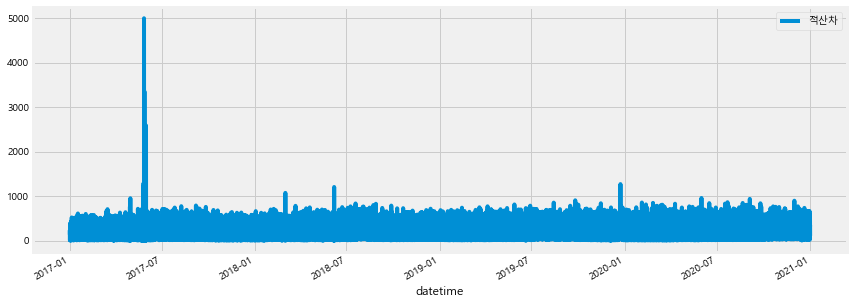

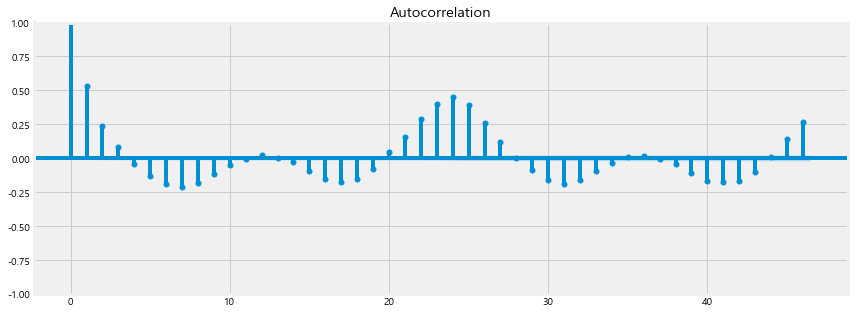

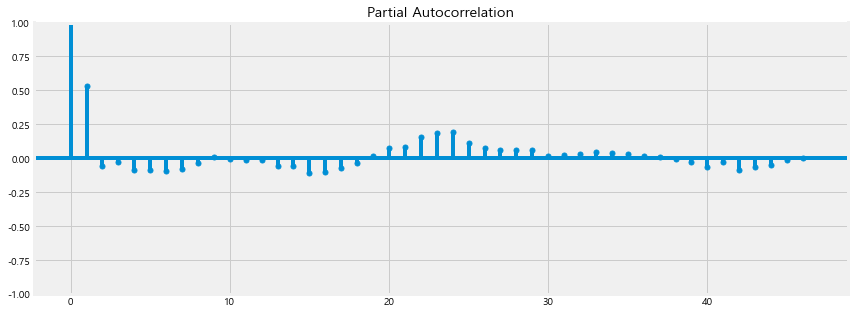

In [20]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plot_acf(data_tr['적산차'])
plot_pacf(data_tr['적산차'])
plt.show()

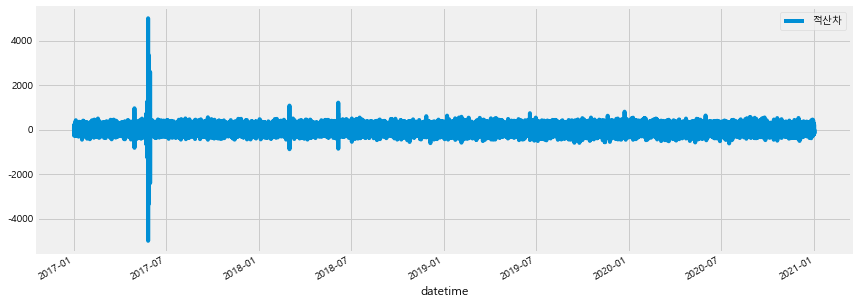

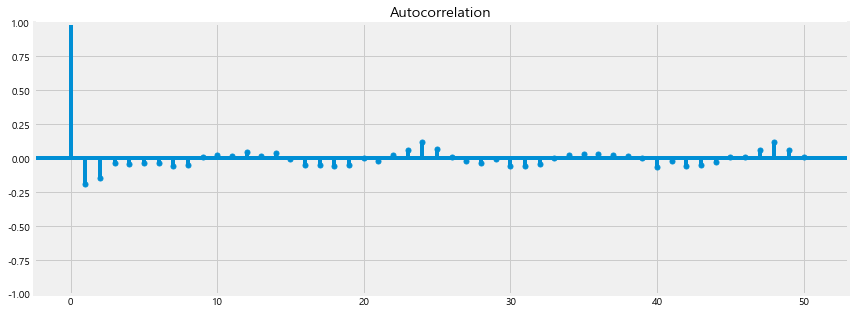

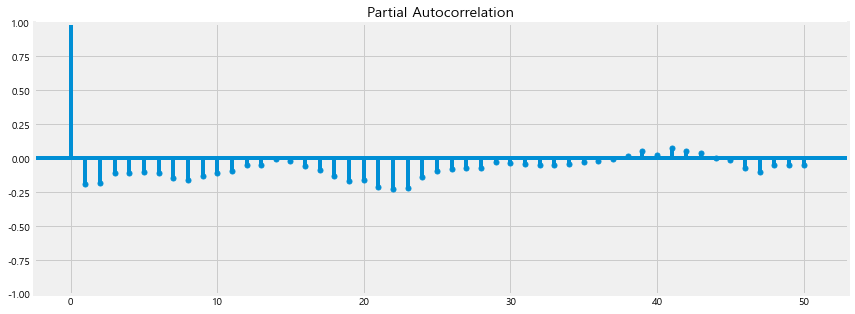

In [21]:
data_tr.diff(1).dropna().plot()
plot_acf(data_tr.diff(1).dropna(), lags=50)
plot_pacf(data_tr.diff(1).dropna(), lags=50)
plt.show()

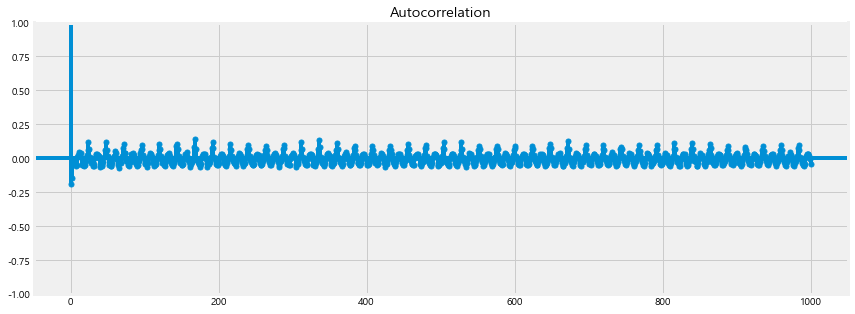

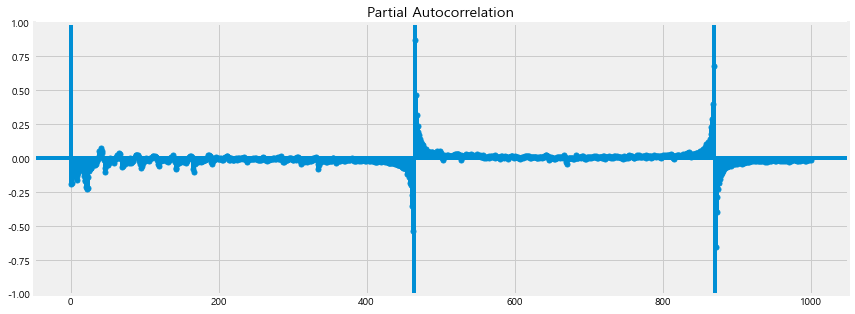

In [23]:
plot_acf(data_tr.diff(1).dropna(), lags=1000)
plot_pacf(data_tr.diff(1).dropna(), lags=1000)
plt.show()

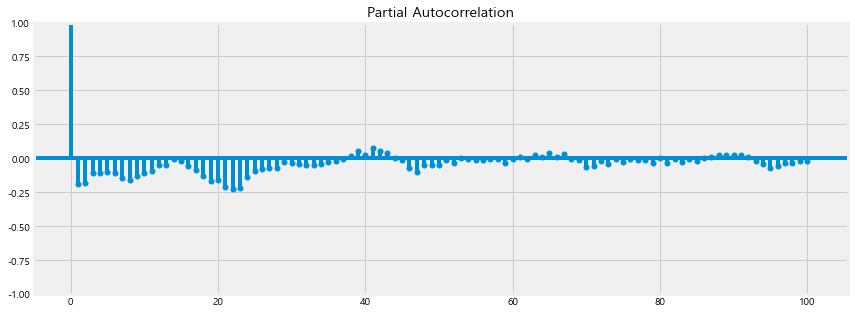

In [44]:
plot_pacf(data_tr.diff(1).dropna(), lags=100)
plt.show()

In [22]:
data_tr = data_tr.to_period('H')
data_tr.index.dtype

period[H]

In [24]:
model = ARIMA(data_tr['적산차'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    적산차   No. Observations:                35060
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -223033.903
Date:                Thu, 24 Nov 2022   AIC                         446077.805
Time:                        12:26:45   BIC                         446120.129
Sample:                    01-01-2017   HQIC                        446091.285
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4619      0.009    -52.337      0.000      -0.479      -0.445
ar.L2          0.5279      0.005     99.753      0.000       0.518       0.538
ma.L1         -0.0059      0.009     -0.676      0.4

In [25]:
forecast = pd.DataFrame(model_fit.predict())

forecast['original'] = list(data_tr.적산차)
forecast.rename(columns={'predicted_mean':'predict'}, inplace=True)
forecast['datetime'] = forecast.index
forecast.reset_index(drop=True, inplace=True)
forecast = forecast[['datetime', 'original', 'predict']]

mae = mean_absolute_error(forecast['original'], forecast['predict'])
print('mae :', mae)

forecast.head()

mae : 105.89138675538612


,datetime,original,predict
0,2017-01-01 01:00,138.0,0.000000
1,2017-01-01 02:00,237.0,137.193612
2,2017-01-01 03:00,128.0,213.149887
3,2017-01-01 04:00,14.0,138.926366
4,2017-01-01 05:00,11.0,58.612914


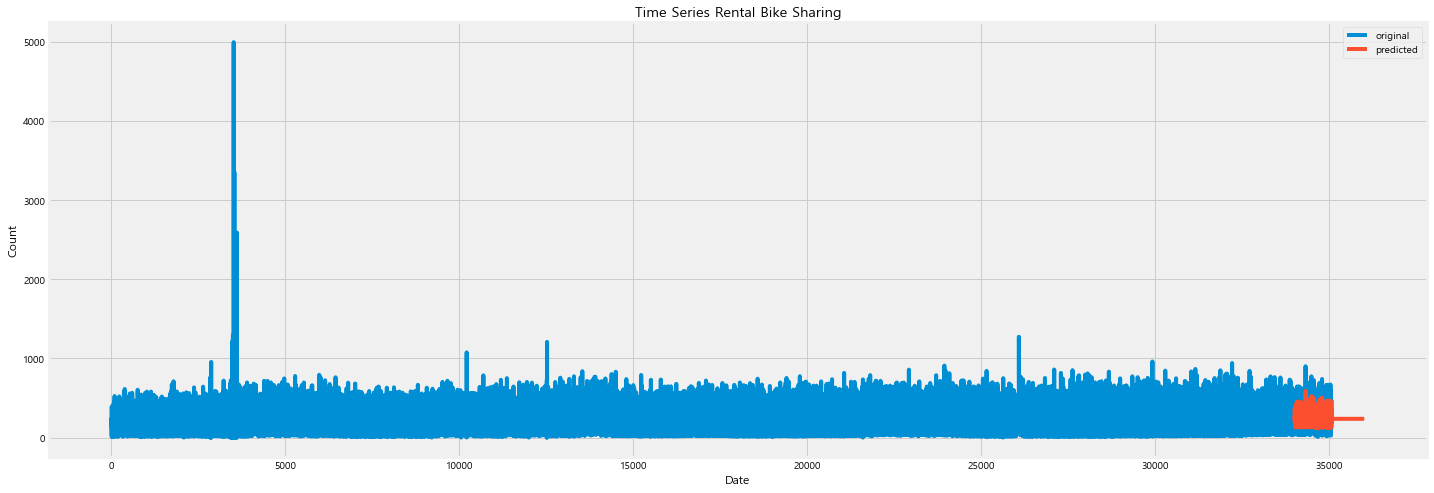

In [81]:
data_tr_arima = data_tr.copy()
data_tr_arima['datetime'] = data_tr.index
data_tr_arima.reset_index(drop=True, inplace=True)
pred = pd.DataFrame(model_fit.predict(start=34000, end=36000)).set_index(pd.Index(range(34000,36001)))
rcParams['figure.figsize'] = 22, 8
plt.plot(data_tr_arima['적산차'], label='original')
plt.plot(pred.predicted_mean, label='predicted')
plt.title('Time Series Rental Bike Sharing')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [88]:
p_range, q_range = range(0,3), range(0,3)
ARIMA_orders = [(x[0], x[1]) for x in list(product(p_range, q_range))]

cnt, best_mae = 0, ' '

for p, q in tqdm(ARIMA_orders):
        cnt += 1
        
        model = ARIMA(data_tr_arima['적산차'], order=(p,1,q))
        model_fit = model.fit()
        
        forecast = pd.DataFrame(model_fit.predict(start=35060, end=35060+8423))
        forecast.reset_index(drop=True, inplace=True)
        forecast['datetime'] = data_ts['datetime']
        forecast['original'] = data_ts.적산차
        forecast.rename(columns={'predicted_mean':'predict'}, inplace=True)

        mae = mean_absolute_error(forecast['original'], forecast['predict'])
        
        if cnt == 1:
            best_mae = mae
        
        if best_mae > mae:
            best_mae, best_mae_p, best_mae_q = mae, p, q
        
        print(f'ARIMA : ({p}, 1, {q}), mae : {mae}, best mae : {best_mae}')
        
        if cnt == 1:
            best_aic = model_fit.aic

        if best_aic > model_fit.aic:
            best_aic, best_aic_p, best_aic_q = model_fit.aic, p, q

        print(f'ARIMA : ({p}, 1, {q}), aic : {model_fit.aic}, best aic : {best_aic}')

 11%|█         | 1/9 [00:00<00:02,  2.88it/s]

ARIMA : (0, 1, 0), mae : 172.24097815764483, best mae : 172.24097815764483
ARIMA : (0, 1, 0), aic : 455412.70245374856, best aic : 455412.70245374856


 22%|██▏       | 2/9 [00:01<00:04,  1.64it/s]

ARIMA : (0, 1, 1), mae : 158.78453549792243, best mae : 158.78453549792243
ARIMA : (0, 1, 1), aic : 453329.9705337964, best aic : 453329.9705337964


 33%|███▎      | 3/9 [00:04<00:09,  1.66s/it]

ARIMA : (0, 1, 2), mae : 140.52233848247192, best mae : 140.52233848247192
ARIMA : (0, 1, 2), aic : 447506.70137384493, best aic : 447506.70137384493


 44%|████▍     | 4/9 [00:04<00:05,  1.17s/it]

ARIMA : (1, 1, 0), mae : 169.8438667940593, best mae : 140.52233848247192
ARIMA : (1, 1, 0), aic : 454121.3434336773, best aic : 447506.70137384493


 56%|█████▌    | 5/9 [00:09<00:10,  2.51s/it]

ARIMA : (1, 1, 1), mae : 140.58647908184997, best mae : 140.52233848247192
ARIMA : (1, 1, 1), aic : 445898.1874200806, best aic : 445898.1874200806


 67%|██████▋   | 6/9 [00:17<00:13,  4.54s/it]

ARIMA : (1, 1, 2), mae : 140.57387358388013, best mae : 140.52233848247192
ARIMA : (1, 1, 2), aic : 445771.77274220815, best aic : 445771.77274220815


 78%|███████▊  | 7/9 [00:18<00:06,  3.28s/it]

ARIMA : (2, 1, 0), mae : 156.78217651129287, best mae : 140.52233848247192
ARIMA : (2, 1, 0), aic : 452908.83340506954, best aic : 445771.77274220815


 89%|████████▉ | 8/9 [00:27<00:05,  5.07s/it]

ARIMA : (2, 1, 1), mae : 139.7520305751836, best mae : 139.7520305751836
ARIMA : (2, 1, 1), aic : 445959.69603129325, best aic : 445771.77274220815


100%|██████████| 9/9 [00:36<00:00,  4.08s/it]

ARIMA : (2, 1, 2), mae : 139.7431218843177, best mae : 139.7431218843177
ARIMA : (2, 1, 2), aic : 446077.8052324788, best aic : 445771.77274220815


In [89]:
# best parameter
print('best_mae_p, best_mae_q, best_mae : {}, {}, {}'.format(best_mae_p, best_mae_q, best_mae))
print('best_aic_p, best_aic_q, best_aic : {}, {}, {}'.format(best_aic_p, best_aic_q, best_aic))

best_mae_p, best_mae_q, best_mae : 2, 2, 139.7431218843177
best_aic_p, best_aic_q, best_aic : 1, 2, 445771.77274220815


In [90]:
model = ARIMA(data_tr_arima['적산차'], order=(best_mae_p,1,best_mae_q))
model_fit = model.fit()

In [91]:
for i, start in enumerate(tqdm(data_sample.index)):
    start = 35060+start
    end = start+335

    forecast = pd.DataFrame(model_fit.predict(start=start, end=end))
    data_sample.loc[i] = [data_sample['datetime'].loc[i]] + list(forecast['predicted_mean'])

data_sample.head()

100%|██████████| 8425/8425 [12:03<00:00, 11.65it/s]


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,170.860581,201.252877,218.289933,226.466062,231.684154,233.590501,235.464818,235.605540,236.530062,...,236.708041,236.642177,236.707603,236.642613,236.707171,236.643042,236.706745,236.643466,236.706324,236.643884
1,2021-01-01 01:00:00,201.252877,218.289933,226.466062,231.684154,233.590501,235.464818,235.605540,236.530062,236.177337,...,236.642177,236.707603,236.642613,236.707171,236.643042,236.706745,236.643466,236.706324,236.643884,236.705908
2,2021-01-01 02:00:00,218.289933,226.466062,231.684154,233.590501,235.464818,235.605540,236.530062,236.177337,236.828341,...,236.707603,236.642613,236.707171,236.643042,236.706745,236.643466,236.706324,236.643884,236.705908,236.644296
3,2021-01-01 03:00:00,226.466062,231.684154,233.590501,235.464818,235.605540,236.530062,236.177337,236.828341,236.341441,...,236.642613,236.707171,236.643042,236.706745,236.643466,236.706324,236.643884,236.705908,236.644296,236.705499
4,2021-01-01 04:00:00,231.684154,233.590501,235.464818,235.605540,236.530062,236.177337,236.828341,236.341441,236.910018,...,236.707171,236.643042,236.706745,236.643466,236.706324,236.643884,236.705908,236.644296,236.705499,236.644703


In [72]:
data_sample.to_csv('./t1_data_city/submission_ARIMA.csv', index=False)

### SARIMA

In [20]:
data_tr = data_tr.to_period('H')
data_tr.index.dtype

period[H]

In [ ]:
freq = 24
p_range, q_range, ps_range, ds_range, qs_range = range(0,3), range(0,3), range(0,3), range(0,2), range(0,3)
SARIMA_orders = [(x[0], x[1], x[2], x[3], x[4]) for x in list(product(p_range, q_range, ps_range, ds_range, qs_range))]

cnt, best_aic = 0, ' '

for p, q, ps, ds, qs in tqdm(SARIMA_orders):
    cnt += 1
    try:
        model = sm.tsa.SARIMAX(data_tr, order=(p,1,q), seasonal_order=(ps,ds,qs,freq))
        model_fit = model.fit(low_memory=True)
        
        forecast = pd.DataFrame(model_fit.predict(start=35060, end=35060+8423))
        forecast.reset_index(drop=True, inplace=True)
        forecast['datetime'] = data_ts['datetime']
        forecast['original'] = data_ts.적산차
        
        mae = mean_absolute_error(forecast['original'], forecast['predicted_mean'])
        
        if cnt == 1:
            best_aic = model_fit.aic
            best_mae = mae

        if best_aic > model_fit.aic:
            best_aic, best_aic_p, best_aic_q, best_aic_ps, best_aic_ds, best_aic_qs = model_fit.aic, p, q, ps, ds, qs       
        if best_mae > mae:
            best_mae, best_mae_p, best_mae_q, best_mae_ps, best_mae_ds, best_aic_qs = mae, p, q, ps, ds, qs
            
        print(f'SARIMA : ({p}, 1, {q}) ({ps}, {ds}, {qs}, 24), aic : {model_fit.aic}, best aic : {best_aic}')
        print(f'SARIMA : ({p}, 1, {q}) ({ps}, {ds}, {qs}, 24), mae : {mae}, best mae : {best_mae}')
        
    except:
        print('except')
        continue

  1%|          | 1/162 [00:00<00:44,  3.58it/s]

SARIMA : (0, 1, 0) (0, 0, 0, 24), aic : 455412.7024537413, best aic : 455412.7024537413
SARIMA : (0, 1, 0) (0, 0, 0, 24), mae : 172.24097815764483, best mae : 172.24097815764483


  1%|          | 2/162 [00:02<04:08,  1.55s/it]

SARIMA : (0, 1, 0) (0, 0, 1, 24), aic : 454970.44480507285, best aic : 454970.44480507285
SARIMA : (0, 1, 0) (0, 0, 1, 24), mae : 173.44875670366878, best mae : 172.24097815764483


  2%|▏         | 3/162 [00:26<31:15, 11.80s/it]

SARIMA : (0, 1, 0) (0, 0, 2, 24), aic : 454616.3088103208, best aic : 454616.3088103208
SARIMA : (0, 1, 0) (0, 0, 2, 24), mae : 173.23358418664162, best mae : 172.24097815764483


  2%|▏         | 4/162 [00:27<19:33,  7.42s/it]

SARIMA : (0, 1, 0) (0, 1, 0, 24), aic : 474755.27020586946, best aic : 454616.3088103208
SARIMA : (0, 1, 0) (0, 1, 0, 24), mae : 3718.861704653352, best mae : 172.24097815764483


  3%|▎         | 5/162 [01:20<1:02:21, 23.83s/it]

SARIMA : (0, 1, 0) (0, 1, 1, 24), aic : 451847.7508294589, best aic : 451847.7508294589
SARIMA : (0, 1, 0) (0, 1, 1, 24), mae : 651.1955611800413, best mae : 172.24097815764483


  4%|▎         | 6/162 [07:38<6:15:22, 144.38s/it]

except


In [56]:
# best parameter
print('best_aic, best_p, best_q, best_ps, best_qs, best_ds : {}, {}, {}, {}, {}, {}'.format(best_aic, best_aic_p, best_aic_q, best_aic_ps, best_aic_ds, best_aic_qs))
print('best_mae, best_p, best_q, best_ps, best_qs, best_ds : {}, {}, {}, {}, {}, {}'.format(best_mae, best_mae_p, best_mae_q, best_mae_ps, best_mae_ds, best_mae_qs))

best_aic, best_p, best_q, best_ps, best_qs, best_ds : 435467.6900922014, 0, 3, 0, 1


In [57]:
model = sm.tsa.SARIMAX(data_tr, order=(p,1,q), seasonal_order=(ps,ds,qs,24))
model_fit = model.fit()

for i, start in enumerate(tqdm(data_sample.index)):
    start = 35060+start
    end = start+335

    forecast = pd.DataFrame(model_fit.predict(start=start, end=end))
    data_sample.loc[i] = [data_sample['datetime'].loc[i]] + list(forecast['predicted_mean'])

data_sample.head()

100%|██████████| 8425/8425 [39:49<00:00,  3.53it/s]


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,158.032064,157.551861,142.342620,104.567033,81.522846,56.174813,57.379275,76.936198,211.620380,...,314.422224,291.300444,253.485179,267.468139,268.479444,368.678214,415.541451,432.171911,356.590462,225.596864
1,2021-01-01 01:00:00,157.551861,142.342620,104.567033,81.522846,56.174813,57.379275,76.936198,211.620380,323.363769,...,291.300444,253.485179,267.468139,268.479444,368.678214,415.541451,432.171911,356.590462,225.596864,187.248074
2,2021-01-01 02:00:00,142.342620,104.567033,81.522846,56.174813,57.379275,76.936198,211.620380,323.363769,338.758991,...,253.485179,267.468139,268.479444,368.678214,415.541451,432.171911,356.590462,225.596864,187.248074,164.301337
3,2021-01-01 03:00:00,104.567033,81.522846,56.174813,57.379275,76.936198,211.620380,323.363769,338.758991,352.005806,...,267.468139,268.479444,368.678214,415.541451,432.171911,356.590462,225.596864,187.248074,164.301337,143.110272
4,2021-01-01 04:00:00,81.522846,56.174813,57.379275,76.936198,211.620380,323.363769,338.758991,352.005806,359.577945,...,268.479444,368.678214,415.541451,432.171911,356.590462,225.596864,187.248074,164.301337,143.110272,103.741922


In [58]:
data_sample.to_csv('./t1_data_city/submission_SARIMA.csv', index=False)

In [ ]:
m1 = pm.auto_arima(data_tr, stepwise=True, error_action='ignore', seasonal=True, m=24*365)